# Task 3: 2X2 pixel inpainting
In this part we need to get the most likely image given both past and futre pixels. In order to do this, all possible outcomes(pixel predictions) are compared and the outcomes of the lowest cost are chossen. This time there is 16 possible outcomes

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import pdb
import matplotlib.image as mpimg
import matplotlib.cm as cm
from itertools import chain
import random
import copy
import pdb

In [2]:
# Need to load the MNist data to work with
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST/", one_hot=True)
# one hot true gives the y labels as vectors with 1's which correspond to the number it is

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
# load images
twobytwopixels_inpainting = np.load('2X2_pixels_inpainting.npy')

In [4]:
# find the missing pixels
missing_pixels = twobytwopixels_inpainting[0,:,:]
pic_GT = twobytwopixels_inpainting[1,:,:]
miss_pix_ind = np.where(missing_pixels == -1)

In [5]:
# reshpape into useable shape
miss_pix_ind =miss_pix_ind[1].reshape(1000,4)

In [6]:
# need to copy the missing pixel image 16 times
# should have used the np.repeat but didn't find it till after

pixels_0000 = copy.deepcopy(missing_pixels)

pixels_1000 = copy.deepcopy(missing_pixels)
pixels_0100 = copy.deepcopy(missing_pixels)
pixels_0010 = copy.deepcopy(missing_pixels)
pixels_0001 = copy.deepcopy(missing_pixels)

pixels_1100 = copy.deepcopy(missing_pixels)
pixels_1010 = copy.deepcopy(missing_pixels)
pixels_1001 = copy.deepcopy(missing_pixels)
pixels_0110 = copy.deepcopy(missing_pixels)
pixels_0101 = copy.deepcopy(missing_pixels)
pixels_0011 = copy.deepcopy(missing_pixels)

pixels_1110 = copy.deepcopy(missing_pixels)
pixels_1101 = copy.deepcopy(missing_pixels)
pixels_1011 = copy.deepcopy(missing_pixels)
pixels_0111 = copy.deepcopy(missing_pixels)
pixels_1111 = copy.deepcopy(missing_pixels)


Need to create the images with the correct missing pixel sequence for the 16 possible combinations.

In [7]:
# do it for the easy cases
for i in range(1000):
    pixels_0000[i,miss_pix_ind[i,:]] = 0
    pixels_1111[i,miss_pix_ind[i,:]] = 1

In [8]:
# Do it for the 14 other images
for i in range(1000):
    for j in range(miss_pix_ind.shape[1]):
        if j == 0:
            pixels_1000[i,miss_pix_ind[i,j]] = 1
            pixels_0100[i,miss_pix_ind[i,j]] = 0
            pixels_0010[i,miss_pix_ind[i,j]] = 0
            pixels_0001[i,miss_pix_ind[i,j]] = 0

            pixels_1100[i,miss_pix_ind[i,j]] = 1
            pixels_1010[i,miss_pix_ind[i,j]] = 1
            pixels_1001[i,miss_pix_ind[i,j]] = 1
            pixels_0110[i,miss_pix_ind[i,j]] = 0
            pixels_0101[i,miss_pix_ind[i,j]] = 0
            pixels_0011[i,miss_pix_ind[i,j]] = 0

            pixels_1110[i,miss_pix_ind[i,j]] = 1
            pixels_1101[i,miss_pix_ind[i,j]] = 1
            pixels_1011[i,miss_pix_ind[i,j]] = 1
            pixels_0111[i,miss_pix_ind[i,j]] = 0
             
            

        elif j == 1:
            pixels_1000[i,miss_pix_ind[i,j]] = 0
            pixels_0100[i,miss_pix_ind[i,j]] = 1
            pixels_0010[i,miss_pix_ind[i,j]] = 0
            pixels_0001[i,miss_pix_ind[i,j]] = 0

            pixels_1100[i,miss_pix_ind[i,j]] = 1
            pixels_1010[i,miss_pix_ind[i,j]] = 0
            pixels_1001[i,miss_pix_ind[i,j]] = 0
            pixels_0110[i,miss_pix_ind[i,j]] = 1
            pixels_0101[i,miss_pix_ind[i,j]] = 1
            pixels_0011[i,miss_pix_ind[i,j]] = 0

            pixels_1110[i,miss_pix_ind[i,j]] = 1
            pixels_1101[i,miss_pix_ind[i,j]] = 1
            pixels_1011[i,miss_pix_ind[i,j]] = 0
            pixels_0111[i,miss_pix_ind[i,j]] = 1      
            
        elif j == 2:
            pixels_1000[i,miss_pix_ind[i,j]] = 0
            pixels_0100[i,miss_pix_ind[i,j]] = 0
            pixels_0010[i,miss_pix_ind[i,j]] = 1
            pixels_0001[i,miss_pix_ind[i,j]] = 0

            pixels_1100[i,miss_pix_ind[i,j]] = 0
            pixels_1010[i,miss_pix_ind[i,j]] = 1
            pixels_1001[i,miss_pix_ind[i,j]] = 0
            pixels_0110[i,miss_pix_ind[i,j]] = 1
            pixels_0101[i,miss_pix_ind[i,j]] = 0
            pixels_0011[i,miss_pix_ind[i,j]] = 1

            pixels_1110[i,miss_pix_ind[i,j]] = 1
            pixels_1101[i,miss_pix_ind[i,j]] = 0
            pixels_1011[i,miss_pix_ind[i,j]] = 1
            pixels_0111[i,miss_pix_ind[i,j]] = 1         
        
        elif j == 3:
            pixels_1000[i,miss_pix_ind[i,j]] = 0
            pixels_0100[i,miss_pix_ind[i,j]] = 0
            pixels_0010[i,miss_pix_ind[i,j]] = 0
            pixels_0001[i,miss_pix_ind[i,j]] = 1

            pixels_1100[i,miss_pix_ind[i,j]] = 0
            pixels_1010[i,miss_pix_ind[i,j]] = 0
            pixels_1001[i,miss_pix_ind[i,j]] = 1
            pixels_0110[i,miss_pix_ind[i,j]] = 0
            pixels_0101[i,miss_pix_ind[i,j]] = 1
            pixels_0011[i,miss_pix_ind[i,j]] = 1

            pixels_1110[i,miss_pix_ind[i,j]] = 0
            pixels_1101[i,miss_pix_ind[i,j]] = 1
            pixels_1011[i,miss_pix_ind[i,j]] = 1
            pixels_0111[i,miss_pix_ind[i,j]] = 1            

In [9]:
def RNN_predict(input_pixels,gt_pixels,rnn_size):


    probs = []

    # GRU layer
    gru_cell = tf.nn.rnn_cell.GRUCell(num_units=rnn_size)
    outputs, state = tf.nn.dynamic_rnn(cell=gru_cell, dtype=tf.float32, inputs=input_pixels)
    # Shape outputs so its batch size=100*484, rnn_size=32
    outputs = tf.reshape(outputs, [-1, rnn_size])
    
    # affine transformation
    outputs = tf.matmul(outputs, weights) + biases
    
    # Reshape so that (batch size,pix_len)
    sampled = tf.reshape(input_pixels,[-1, 784])
    #gt = tf.reshape(gt_pixels,[-1, 784])
    gt = gt_pixels
    logits = tf.reshape((outputs), [-1, 784])
    # Calculate the cost between the ground truth image and the probs(outcomes)    
    cost_gt_out = -tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(targets=gt[:,1:], logits=logits[:,:-1]), axis = 1)
    
    # Calculate the cost between the image you sampled and the probs(outcomes)    
    cost_sample = -tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(targets=sampled[:,1:], logits=logits[:,:-1]), axis = 1)
    
    #outputs = tf.reshape(tf.nn.sigmoid(outputs), [-1, 784])
    return cost_sample,cost_gt_out
   

Set up the placeholders, variables and parameters

In [10]:
n_classes = 10
batch_size = 100
chunk_size = 1
n_chunks = 784
rnn_size = 128
first_pix = 484
#seq_len = 10
#
#full = first_pix+seq_len
sampled_seq_list =[]
cost_list=[]
cost_values = []
n_samples = 10
random.seed(10)
seq_len = miss_pix_ind

# Define the placeholders that will be used
x = tf.placeholder('float', [None, n_chunks,chunk_size])
y = tf.placeholder('float', [None, n_chunks])

# Taking the first 484 pixels of the fitst 100 images
x_in_paint = x[:,0:first_pix,:]

logs_path = '/tmp/tensorflow_logs/example'

In [11]:
weights = tf.Variable(tf.random_normal([rnn_size, 1]))
biases =  tf.Variable(tf.random_normal([1]))

In [12]:
def binarize(images, threshold=0.1):
    return (threshold < images).astype('float32')

In [13]:
# Set up the graph to be run
cost_sampled, cost_gt = RNN_predict(x,y,rnn_size)

In [14]:
# Store the images in a list
pixel_list = []

pixel_list.append(pixels_0000)
pixel_list.append(pixels_1000)
pixel_list.append(pixels_0100)
pixel_list.append(pixels_0010)
pixel_list.append(pixels_0001)
pixel_list.append(pixels_1100)
pixel_list.append(pixels_1010)
pixel_list.append(pixels_1001)
pixel_list.append(pixels_0110)
pixel_list.append(pixels_0101)
pixel_list.append(pixels_0011)
pixel_list.append(pixels_1110)
pixel_list.append(pixels_1101)
pixel_list.append(pixels_1011)
pixel_list.append(pixels_0111)
pixel_list.append(pixels_1111)

In [15]:
init = tf.global_variables_initializer()
cost_samp_list = []
cost_gt_list = []
with tf.Session() as sess:    
    sess.run(init)
    start = time.time()
    save_MDir = 'models/Task2/gru128/'
    save_model = os.path.join(save_MDir,'best_accuracy_3')
    saver2restore = tf.train.Saver()
    saver2restore.restore(sess = sess, save_path= save_model)
    
    # feed in each image and calculate the gt cost and the sampled cost for each set of images
    for image in range(len(pixel_list)):
        
        batch_x = pixel_list[image]
        batch_x = binarize(batch_x)
        batch_x = batch_x.reshape(1000,784,chunk_size)

        # main work done here
        cost_samp,cost_gts = sess.run([cost_sampled,cost_gt],feed_dict={x:batch_x, y:pic_GT})
        cost_samp_list.append(cost_samp)
        cost_gt_list.append(cost_gts)
        print('Time to process {} set of images: {}'.format(image+1,time.time()-start))
       
    
  

Time to process 1 set of images: 5.104594469070435
Time to process 2 set of images: 10.282800674438477
Time to process 3 set of images: 15.241260528564453
Time to process 4 set of images: 20.360339879989624
Time to process 5 set of images: 25.114092588424683
Time to process 6 set of images: 30.072290658950806
Time to process 7 set of images: 34.910362243652344
Time to process 8 set of images: 39.79884219169617
Time to process 9 set of images: 45.01382899284363
Time to process 10 set of images: 51.213409662246704
Time to process 11 set of images: 56.38880705833435
Time to process 12 set of images: 61.421570777893066
Time to process 13 set of images: 66.47544884681702
Time to process 14 set of images: 71.53541445732117
Time to process 15 set of images: 76.37879085540771
Time to process 16 set of images: 81.40509486198425


Need to find the image which has the lowest cost. Stack them all togerther and take the argmax(since its negative)

In [16]:
compare = cost_samp_list[0]

compare =compare.reshape(1000,1)
count = 1
for i in range(len(cost_samp_list)-1):
    #pdb.set_trace()
    compare = np.append(compare,cost_samp_list[count].reshape(1000,1),axis=1)
    count+=1

In [17]:
predictions = np.argmax(compare, axis = 1)

In [18]:
# get the possible sequence in an array
list_miss_numbers = []

list_miss_numbers.append([0,0,0,0])
list_miss_numbers.append([1,0,0,0])
list_miss_numbers.append([0,1,0,0])
list_miss_numbers.append([0,0,1,0])
list_miss_numbers.append([0,0,0,1])
list_miss_numbers.append([1,1,0,0])
list_miss_numbers.append([1,0,1,0])
list_miss_numbers.append([1,0,0,1])
list_miss_numbers.append([0,1,1,0])
list_miss_numbers.append([0,1,0,1])
list_miss_numbers.append([0,0,1,1])
list_miss_numbers.append([1,1,1,0])
list_miss_numbers.append([1,1,0,1])
list_miss_numbers.append([1,0,1,1])
list_miss_numbers.append([0,1,1,1])
list_miss_numbers.append([1,1,1,1])

list_miss_numbers = np.asarray(list_miss_numbers)


Need to do the same as one pixel case but need to compare over 16 images. Each does the same but for the specific sequnece. Here the smapled cost and ground truth cost are calculated for the predicted list of images.

In [19]:
ml_Xent = 0
gt_Xent =0
pred_image = []
accuracy = 0
accuracy_pixel = 0
count =0

mistake_list = []

for i in range(1000):
    if predictions[i]==0:
        k = predictions[i]
        ml_Xent += -cost_samp_list[k][i]
        gt_Xent += -cost_gt_list[k][i]
        pred_image.append(pixel_list[k][i,:])
        count+=1
        for pix in range (4):
            if list_miss_numbers[k,pix] == pic_GT[i, miss_pix_ind[i,pix]]:
                accuracy_pixel+=1
                
        if all(list_miss_numbers[k,:] == pic_GT[i, miss_pix_ind[i,:]]):
            accuracy +=1
        else:            
            mistake_list.append(i)
            
    elif predictions[i]==1:
        k = predictions[i]
        ml_Xent += -cost_samp_list[k][i]
        gt_Xent += -cost_gt_list[k][i]
        pred_image.append(pixel_list[k][i,:])
        count+=1
        for pix in range (4):
            if list_miss_numbers[k,pix] == pic_GT[i, miss_pix_ind[i,pix]]:
                accuracy_pixel+=1

        if all(list_miss_numbers[k,:] == pic_GT[i, miss_pix_ind[i,:]]):
            accuracy +=1
        else:            
            mistake_list.append(i)
    elif predictions[i]==2:
        k = predictions[i]
        ml_Xent += -cost_samp_list[k][i]
        gt_Xent += -cost_gt_list[k][i]
        pred_image.append(pixel_list[k][i,:])
        count+=1
        for pix in range (4):
            if list_miss_numbers[k,pix] == pic_GT[i, miss_pix_ind[i,pix]]:
                accuracy_pixel+=1
        
        if all(list_miss_numbers[k,:] == pic_GT[i, miss_pix_ind[i,:]]):
            accuracy +=1
        else:            
            mistake_list.append(i)
    elif predictions[i]==3:
        k = predictions[i]
        ml_Xent += -cost_samp_list[k][i]
        gt_Xent += -cost_gt_list[k][i]
        pred_image.append(pixel_list[k][i,:])
        count+=1
        for pix in range (4):
            if list_miss_numbers[k,pix] == pic_GT[i, miss_pix_ind[i,pix]]:
                accuracy_pixel+=1
        
        if all(list_miss_numbers[k,:] == pic_GT[i, miss_pix_ind[i,:]]):
            accuracy +=1
        else:            
            mistake_list.append(i)
            
    elif predictions[i]==4:
        k = predictions[i]
        ml_Xent += -cost_samp_list[k][i]
        gt_Xent += -cost_gt_list[k][i]
        pred_image.append(pixel_list[k][i,:])
        count+=1
        for pix in range (4):
            if list_miss_numbers[k,pix] == pic_GT[i, miss_pix_ind[i,pix]]:
                accuracy_pixel+=1
        
        if all(list_miss_numbers[k,:] == pic_GT[i, miss_pix_ind[i,:]]):
            accuracy +=1
        else:            
            mistake_list.append(i)
            
            
    elif predictions[i]==5:
        k = predictions[i]
        ml_Xent += -cost_samp_list[k][i]
        gt_Xent += -cost_gt_list[k][i]
        pred_image.append(pixel_list[k][i,:])
        count+=1
        for pix in range (4):
            if list_miss_numbers[k,pix] == pic_GT[i, miss_pix_ind[i,pix]]:
                accuracy_pixel+=1
        
        if all(list_miss_numbers[k,:] == pic_GT[i, miss_pix_ind[i,:]]):
            accuracy +=1
        else:            
            mistake_list.append(i)
            
    elif predictions[i]==6:
        k = predictions[i]
        ml_Xent += -cost_samp_list[k][i]
        gt_Xent += -cost_gt_list[k][i]
        pred_image.append(pixel_list[k][i,:])
        count+=1
        for pix in range (4):
            if list_miss_numbers[k,pix] == pic_GT[i, miss_pix_ind[i,pix]]:
                accuracy_pixel+=1
        
        if all(list_miss_numbers[k,:] == pic_GT[i, miss_pix_ind[i,:]]):
            accuracy +=1
        else:            
            mistake_list.append(i)
            
    elif predictions[i]==7:
        k = predictions[i]
        ml_Xent += -cost_samp_list[k][i]
        gt_Xent += -cost_gt_list[k][i]
        pred_image.append(pixel_list[k][i,:])
        count+=1
        for pix in range (4):
            if list_miss_numbers[k,pix] == pic_GT[i, miss_pix_ind[i,pix]]:
                accuracy_pixel+=1
        
        if all(list_miss_numbers[k,:] == pic_GT[i, miss_pix_ind[i,:]]):
            accuracy +=1
        else:            
            mistake_list.append(i)
            
    elif predictions[i]==8:
        k = predictions[i]
        ml_Xent += -cost_samp_list[k][i]
        gt_Xent += -cost_gt_list[k][i]
        pred_image.append(pixel_list[k][i,:])
        count+=1
        for pix in range (4):
            if list_miss_numbers[k,pix] == pic_GT[i, miss_pix_ind[i,pix]]:
                accuracy_pixel+=1
        
        if all(list_miss_numbers[k,:] == pic_GT[i, miss_pix_ind[i,:]]):
            accuracy +=1
        else:            
            mistake_list.append(i)
            
    elif predictions[i]==9:
        k = predictions[i]
        ml_Xent += -cost_samp_list[k][i]
        gt_Xent += -cost_gt_list[k][i]
        pred_image.append(pixel_list[k][i,:])
        count+=1
        for pix in range (4):
            if list_miss_numbers[k,pix] == pic_GT[i, miss_pix_ind[i,pix]]:
                accuracy_pixel+=1
        
        if all(list_miss_numbers[k,:] == pic_GT[i, miss_pix_ind[i,:]]):
            accuracy +=1
        else:            
            mistake_list.append(i)
            
    elif predictions[i]==10:
        k = predictions[i]
        ml_Xent += -cost_samp_list[k][i]
        gt_Xent += -cost_gt_list[k][i]
        pred_image.append(pixel_list[k][i,:])
        count+=1
        for pix in range (4):
            if list_miss_numbers[k,pix] == pic_GT[i, miss_pix_ind[i,pix]]:
                accuracy_pixel+=1
        
        if all(list_miss_numbers[k,:] == pic_GT[i, miss_pix_ind[i,:]]):
            accuracy +=1
        else:            
            mistake_list.append(i)
            
    elif predictions[i]==11:
        k = predictions[i]
        ml_Xent += -cost_samp_list[k][i]
        gt_Xent += -cost_gt_list[k][i]
        pred_image.append(pixel_list[k][i,:])
        count+=1
        for pix in range (4):
            if list_miss_numbers[k,pix] == pic_GT[i, miss_pix_ind[i,pix]]:
                accuracy_pixel+=1
        
        if all(list_miss_numbers[k,:] == pic_GT[i, miss_pix_ind[i,:]]):
            accuracy +=1
        else:            
            mistake_list.append(i)
            
    elif predictions[i]==12:
        k = predictions[i]
        ml_Xent += -cost_samp_list[k][i]
        gt_Xent += -cost_gt_list[k][i]
        pred_image.append(pixel_list[k][i,:])
        count+=1
        for pix in range (4):
            if list_miss_numbers[k,pix] == pic_GT[i, miss_pix_ind[i,pix]]:
                accuracy_pixel+=1
        
        if all(list_miss_numbers[k,:] == pic_GT[i, miss_pix_ind[i,:]]):
            accuracy +=1
        else:            
            mistake_list.append(i)
            
    elif predictions[i]==13:
        k = predictions[i]
        ml_Xent += -cost_samp_list[k][i]
        gt_Xent += -cost_gt_list[k][i]
        pred_image.append(pixel_list[k][i,:])
        count+=1
        for pix in range (4):
            if list_miss_numbers[k,pix] == pic_GT[i, miss_pix_ind[i,pix]]:
                accuracy_pixel+=1
        
        if all(list_miss_numbers[k,:] == pic_GT[i, miss_pix_ind[i,:]]):
            accuracy +=1
        else:            
            mistake_list.append(i)
            
    elif predictions[i]==14:
        k = predictions[i]
        ml_Xent += -cost_samp_list[k][i]
        gt_Xent += -cost_gt_list[k][i]
        pred_image.append(pixel_list[k][i,:])
        count+=1
        for pix in range (4):
            if list_miss_numbers[k,pix] == pic_GT[i, miss_pix_ind[i,pix]]:
                accuracy_pixel+=1
        
        if all(list_miss_numbers[k,:] == pic_GT[i, miss_pix_ind[i,:]]):
            accuracy +=1
        else:            
            mistake_list.append(i)
            
    elif predictions[i]==15:
        k = predictions[i]
        ml_Xent += -cost_samp_list[k][i]
        gt_Xent += -cost_gt_list[k][i]
        pred_image.append(pixel_list[k][i,:])
        count+=1
        for pix in range (4):
            if list_miss_numbers[k,pix] == pic_GT[i, miss_pix_ind[i,pix]]:
                accuracy_pixel+=1
        
        if all(list_miss_numbers[k,:] == pic_GT[i, miss_pix_ind[i,:]]):
            accuracy +=1
        else:            
            mistake_list.append(i)        
        

In [20]:
print('The maximum likelihood average loss is: {:.6}'.format(ml_Xent/1000))
print('The ground truth average loss is: {:.6}'.format(gt_Xent/1000))
print('The number of correctly patches is : {:.1%}'.format(accuracy/1000))
print('The number of correctly pixels is : {:.1%}'.format(accuracy_pixel/4000))

The maximum likelihood average loss is: 60.7339
The ground truth average loss is: 60.954
The number of correctly patches is : 79.7%
The number of correctly pixels is : 93.4%


### Save the images 

In [21]:
submit_images = np.asarray(pred_image)
submit_images =submit_images.reshape(1,1000,784)
submit_images.shape

(1, 1000, 784)

In [22]:
new_inpaintings = np.append(twobytwopixels_inpainting,submit_images,axis = 0)

In [23]:
#np.save('2X2_pixels_inpainting.npy', new_inpaintings)

In [24]:
reloaded_model =  np.load('2X2_pixels_inpainting.npy')

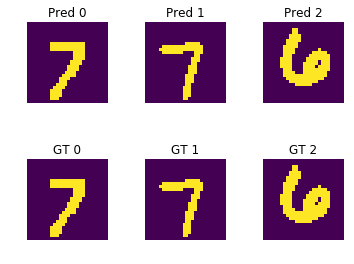

In [25]:
my_images = reloaded_model[2,:,:]
gt_images = reloaded_model[1,:,:]
masked_images = reloaded_model[0,:,:]
f2, axar = plt.subplots(2, 3)

#correct images
for i in range(3):
    axar[0, i].imshow(my_images[i,:].reshape(28,28))
    axar[0, i].set_title('Pred {}'.format(i))
    axar[0, i].axis('off')

    axar[1, i].imshow(gt_images[i,:].reshape(28,28))
    axar[1, i].set_title('GT {}'.format(i))
    axar[1, i].axis('off')
    
f2.subplots_adjust(hspace=0.7)
#plt.savefig('C:/Users/Alex/.ipython/CW2/models/Task2/images/2by2_good.png', dpi =150)
plt.show()

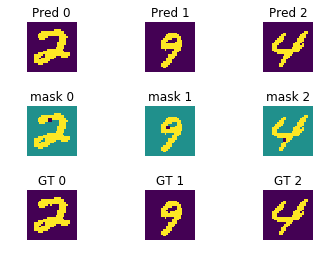

In [26]:
f2, axar = plt.subplots(3, 3)
#mistakes
for i in range(3):
    axar[0, i].imshow(my_images[mistake_list[i],:].reshape(28,28))
    axar[0, i].set_title('Pred {}'.format(i))
    axar[0, i].axis('off')
    
    axar[1, i].imshow(masked_images[mistake_list[i],:].reshape(28,28))
    axar[1, i].set_title('mask {}'.format(i))
    axar[1, i].axis('off')    
    
    
    axar[2, i].imshow(gt_images[mistake_list[i],:].reshape(28,28))
    axar[2, i].set_title('GT {}'.format(i))
    axar[2, i].axis('off')
    
f2.subplots_adjust(hspace=0.7)
#plt.savefig('C:/Users/Alex/.ipython/CW2/models/Task2/images/2by2_mistake.png', dpi =150)
plt.show()